# Accelerate your Python code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time

def benchmark(func):
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        stop = time()
        return result, stop - start
    return wrapper

## Successive over-relaxation in 1D

We copy/paste some code from urban-broccoli and decorate it:

In [2]:
@benchmark
def solve_sor(rho, hx, maxiter, maxerr):
    if rho.ndim != 1:
        raise ValueError("rho must be of shape=(n,)")
    phi = np.zeros(shape=rho.shape, dtype=rho.dtype)
    nx = rho.shape[0]
    mr = hx * hx / 1.0 # epsilon
    w = 2.0 / (1.0 + np.pi / float(nx))
    for iteration in range(maxiter):
        error = 0.0
        for x in range(nx):
            if x % 2 == 0: continue
            phi_x = (
                phi[(x - 1) % nx] + \
                phi[(x + 1) % nx] + \
                rho[x] * mr) / 2.0
            phi[x] = (1.0 - w) * phi[x] + w * phi_x
            error += (phi[x] - phi_x)**2
        for x in range(nx):
            if x % 2 != 0: continue
            phi_x = (
                phi[(x - 1) % nx] + \
                phi[(x + 1) % nx] + \
                rho[x] * mr) / 2.0
            phi[x] = (1.0 - w) * phi[x] + w * phi_x
            error += (phi[x] - phi_x)**2
        if error < maxerr:
            break
    return phi, error, iteration + 1

Now, we build a grid and evaluate some periodic and mean free function `rho` on it which we pass to our solver:

Stopped after 1732 steps with error 4.015306e-16 and walltime 4.7 seconds


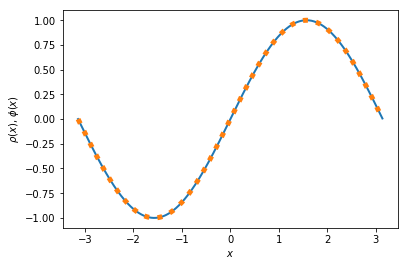

In [3]:
x = np.linspace(-np.pi, np.pi, 1000, endpoint=False)
hx = x[1] - x[0]
rho = np.sin(x)

(phi, error, steps), walltime = solve_sor(rho, hx, 10000, 1e-15)
print('Stopped after %d steps with error %e and walltime %.1f seconds' % (steps, error, walltime))

plt.plot(x, rho, '-', linewidth=2)
plt.plot(x, phi, ':', linewidth=5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$, $\phi(x)$')

Let's increase the grid size...

Stopped after 2887 steps with error 6.480970e-16 and walltime 13.2 seconds


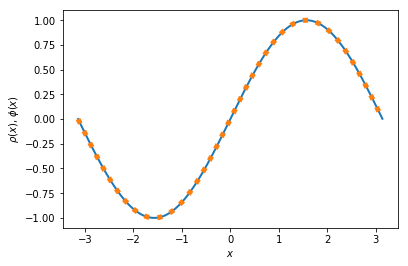

In [4]:
x = np.linspace(-np.pi, np.pi, 2000, endpoint=False)
hx = x[1] - x[0]
rho = np.sin(x)

(phi, error, steps), walltime = solve_sor(rho, hx, 10000, 1e-15)
print('Stopped after %d steps with error %e and walltime %.1f seconds' % (steps, error, walltime))

plt.plot(x, rho, '-', linewidth=2)
plt.plot(x, phi, ':', linewidth=5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$, $\phi(x)$')

I wonder how that scales...

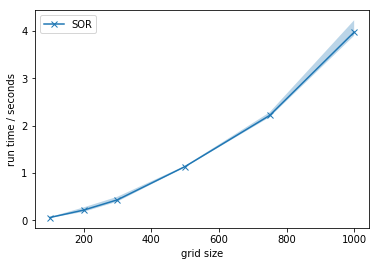

In [5]:
dt_sor = []
nx_sor = [100, 200, 300, 500, 750, 1000]
for nx in nx_sor:
    x = np.linspace(-np.pi, np.pi, nx, endpoint=False)
    hx = x[1] - x[0]
    rho = np.sin(x)
    dt_sor.append([
        solve_sor(rho, hx, 10000, 1e-15)[1] for _ in range(10)])
dt_sor = np.asarray(dt_sor)

plt.fill_between(
    nx_sor,
    np.percentile(dt_sor, 5, axis=1),
    np.percentile(dt_sor, 95, axis=1),
    facecolor='C0', alpha=0.3)
plt.plot(
    nx_sor, np.mean(dt_sor, axis=1),
    '-x', color='C0', label='SOR')
plt.xlabel('grid size')
plt.ylabel('run time / seconds')
plt.legend()

## Introducing numba

Step 1: install `numba` via

```
conda install numba
```

Step 2: We copy/paste/rename the above function and add the `numba.jit` decorator...

```python
@numba.jit(nopython=True)
```

In [6]:
import numba
@benchmark
@numba.jit(nopython=True)
def solve_sor_jit(rho, hx, maxiter, maxerr):
    if rho.ndim != 1:
        raise ValueError("rho must be of shape=(n,)")
    phi = np.zeros(shape=rho.shape, dtype=rho.dtype)
    nx = rho.shape[0]
    mr = hx * hx / 1.0 # epsilon
    w = 2.0 / (1.0 + np.pi / float(nx))
    for iteration in range(maxiter):
        error = 0.0
        for x in range(nx):
            if x % 2 == 0: continue
            phi_x = (
                phi[(x - 1) % nx] + \
                phi[(x + 1) % nx] + \
                rho[x] * mr) / 2.0
            phi[x] = (1.0 - w) * phi[x] + w * phi_x
            error += (phi[x] - phi_x)**2
        for x in range(nx):
            if x % 2 != 0: continue
            phi_x = (
                phi[(x - 1) % nx] + \
                phi[(x + 1) % nx] + \
                rho[x] * mr) / 2.0
            phi[x] = (1.0 - w) * phi[x] + w * phi_x
            error += (phi[x] - phi_x)**2
        if error < maxerr:
            break
    return phi, error, iteration + 1

...and put it to the test:

Stopped after 1732 steps with error 4.015306e-16 and walltime 0.4 seconds


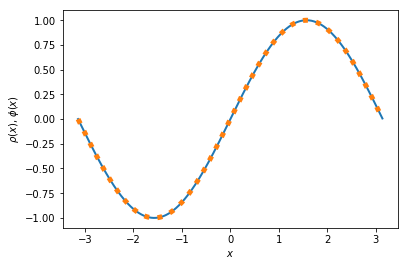

In [7]:
(phi, error, steps), walltime = solve_sor_jit(rho, hx, 10000, 1e-15)
print('Stopped after %d steps with error %e and walltime %.1f seconds' % (steps, error, walltime))

plt.plot(x, rho, '-', linewidth=2)
plt.plot(x, phi, ':', linewidth=5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$, $\phi(x)$')

That was quick! I wonder how that scales...

In [8]:
dt_jit = []
nx_jit = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
for nx in nx_jit:
    x = np.linspace(-np.pi, np.pi, nx, endpoint=False)
    hx = x[1] - x[0]
    rho = np.sin(x)
    dt_jit.append([
        solve_sor_jit(rho, hx, 20000, 1e-15)[1] for _ in range(10)])
dt_jit = np.asarray(dt_jit)

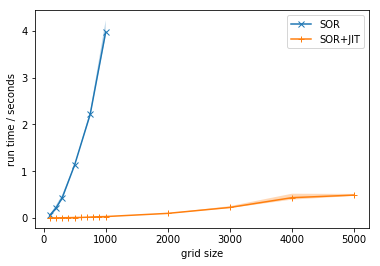

In [9]:
plt.fill_between(
    nx_sor,
    np.percentile(dt_sor, 5, axis=1),
    np.percentile(dt_sor, 95, axis=1),
    facecolor='C0', alpha=0.3)
plt.fill_between(
    nx_jit,
    np.percentile(dt_jit, 5, axis=1),
    np.percentile(dt_jit, 95, axis=1),
    facecolor='C1', alpha=0.3)
plt.plot(
    nx_sor, np.mean(dt_sor, axis=1),
    '-x', color='C0', label='SOR')
plt.plot(
    nx_jit, np.mean(dt_jit, axis=1),
    '-+', color='C1', label='SOR+JIT')
plt.xlabel('grid size')
plt.ylabel('run time / seconds')
plt.legend()

And that is just the CPU! The decorator

```python
@numba.cuda.jit
```

compiles your python function into a CUDA kernel which runs on a GPU.